# SIFT detector

SIFT stands for Scale-Invariant Feature Transform and was first presented in 2004, by D.Lowe, University of British Columbia. 

SIFT is invariance to image scale and rotation. This algorithm is patented, anyone needs to pay to use it.

It is similar to the the system used in primate visual system. 


<center><img src="https://www.researchgate.net/profile/Jasmin-Velagic/publication/328991586/figure/fig1/AS:750726502424577@1555998554376/Feature-matching-and-object-detection-using-ORB-a-BRISK-b-SIFT-c-or-SURF-d.ppm"></center>


SIFT goals : 
- Extract distinctive invariant features
- Invariance to image scale and rotation
- Robustness to affine distortion, changing in 3D viewpoint, noise



In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math
import time
from scipy import ndimage

# 💎  Steps for Extracting Interest Points

<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200517234610/C5BBC774-8499-4561-BDF6-D8D2499773F3-1024x323.png"></center>

## 🌄1. Scale-space peak Selection

Real world objects are meaningful only at a certain scale. You might see a sugar cube perfectly on a table. But if looking at the entire milky way, then it simply does not exist. This multi-scale nature of objects is quite common in nature. And a scale space attempts to replicate this concept on digital images.


We need to identify the most distinct and meaningful features in a given image while ignoring any noise. Additionally, we need to ensure that the features are not scale-dependent. These are critical concepts so let’s talk about them one-by-one.

We use the **Gaussian Blurring** technique to reduce the noise in an image.


In [109]:
test_img = cv.imread('data/eren.jpg',0)
blured_img = cv.GaussianBlur(test_img,(5,5),100,100)

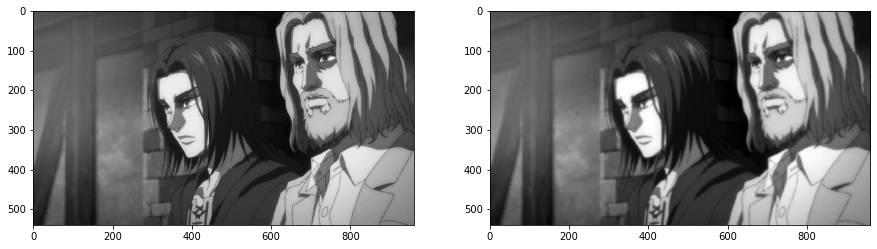

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(test_img,cmap='gray')
ax2.imshow(blured_img,cmap='gray')

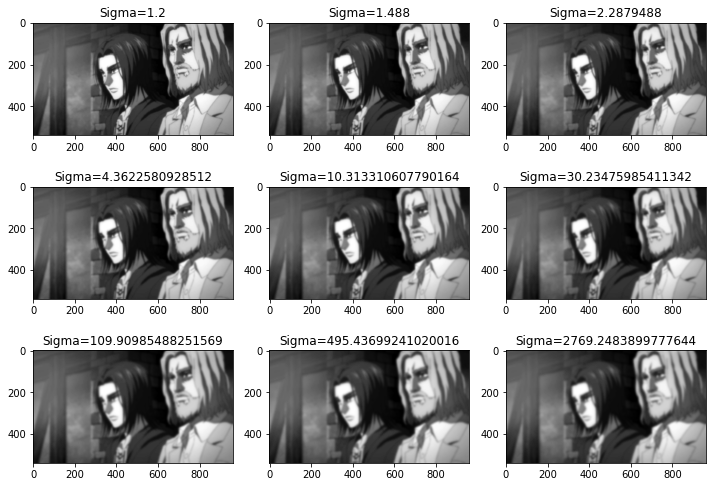

In [112]:
fig, axs = plt.subplots(3,3, figsize=(10,7))
axs = axs.ravel()
sigma = 1.2
k = 1.24
s = 1/math.sqrt(2)

for i in range(1,10):
    blured_img = cv.GaussianBlur(blured_img,(5,5),sigmaX=sigma)
    axs[i-1].imshow(blured_img, cmap='gray')
    axs[i-1].set_title('Sigma=%s' % sigma)
    sigma = sigma*k**i
    plt.tight_layout()

Gaussian Blur successfully removed the noise from the images and we have highlighted the important features of the image. Now, we need to ensure that these features must not be scale-dependent. 

This means we will be searching for these features on multiple scales, by creating a *scale space*.

Scale space is a collection of images having different scales, generated from a single image.

Hence, these blur images are created for multiple scales. To create a new set of images of different scales, we will take the original image and reduce the scale by half. For each new image, we will create blur versions as we saw above.

**Scale Space Peak Selection** depends on the Spatial Coincidence Assumption. According to this, if an edge is detected at the same location in multiple scales (indicated by zero crossings in the scale space) then we classify it as an actual edge.


The scale space of an image is a function $L(x,y,\sigma)$ that is produced from the convolution of a Gaussian kernel(Blurring) at different scales with the input image. Scale-space is separated into octaves and the number of octaves and scale depends on the size of the original image. So we generate several octaves of the original image. Each octave’s image size is half the previous one.

- 1. Blurring
$$L(x,y,\sigma) = G(x,y,\sigma)\star I(x,y) $$

$G$ is the Gaussian Blur operator and $I$ is an image. While $x$ and$y$ are the location coordinates and $\sigma$ is the “scale” parameter. Think of it as the amount of blur. Greater the value, greater the blur.

- 2. DOG(Difference of Gaussian kernel)

Now we use those blurred images to generate another set of images, the Difference of Gaussians (DoG). These DoG images are great for finding out interesting keypoints in the image. The difference of Gaussian is obtained as the difference of Gaussian blurring of an image with two different $\sigma$

<center><img src="https://docs.opencv.org/4.x/sift_dog.jpg"></center>
In fact, it's way more complicated than that. Building a scale space require choosing number of scales per octave to be able to capture most of the repeatable interest points.


<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200518221935/F60FA5DE-EF38-4B7E-89D1-CBD432D80CC8-1024x696.png" width=450></center>

One pixel in an image is compared with its 8 neighbors as well as 9 pixels in the next scale and 9 pixels in previous scales. This way, a total of 26 checks are made. If it is a local extrema, it is a potential keypoint. It basically means that keypoint is best represented in that scale.


In 2D images, we can detect the Interest Points using the local maxima/minima in Scale Space of Laplacian of Gaussian. 

A potential SIFT interest point is determined for a given sigma value by picking the potential interest point and considering the pixels in the level above (with higher sigma), the same level, and the level below (with lower sigma than current sigma level). If the point is maxima/minima of all these 26 neighboring points, it is a potential SIFT interest point – and it acts as a starting point for interest point detection.


## 🔻 2. Key Point Localization

Key-points generated in the previous step produce a lot of keypoints. Some of them lie along an edge, or they don’t have enough contrast. In both cases, they are not as useful as features. So we get rid of them. The approach is similar to the one used in the Harris Corner Detector for removing edge features. For low contrast features, we simply check their intensities.

<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200518225323/0261CA10-1DF1-42A2-B3CC-14354F451621-1024x483.jpg"></center>


Taylor series expansion of scale space are used to get a more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected. 

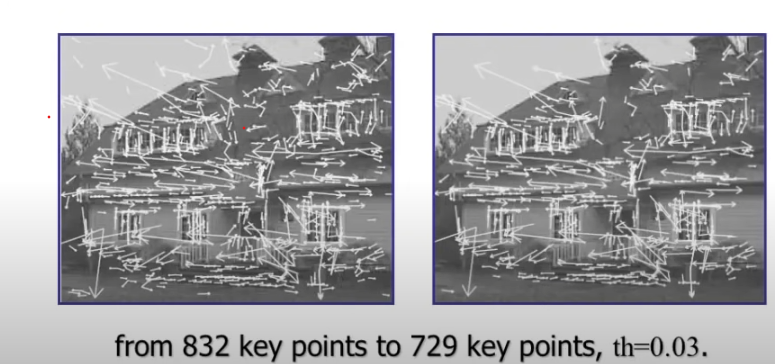

In [134]:
from IPython.display import Image

Image(filename="data/outliers_rejection.png",width=600)

*DoG has a higher response for edges*, so edges also need to be removed.

A 2x2 Hessian matrix (H) is used to compute the principal curvature. This way, edges will be removed.

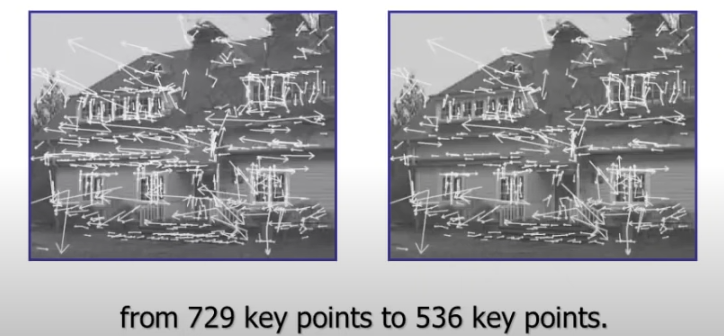

In [135]:
Image(filename="data/hessian.png",width=600)

## 🧭 3. Assigning Orientation to Keypoints

In order to achieve rotation invariance, we have to compute the central derivative, gradient magnitude and direction of $L$ at the scale of key point.


We already know the scale at which the keypoint was detected (it’s the same as the scale of the blurred image). So we have scale invariance. The next thing is to assign an orientation to each keypoint to make it rotation invariance.

Around *that* interest point, we are going to look at the orientation of each of these points by building a weighted direction histogram of **36 bins** (covering $360°$ directions, each of the bin will be of of $10°$). 

- We select the peak (highest value of histogram) as direction of the keypoint (*any peak above 80% of it is also considered to calculate the orientation*).


## 📊 4. Key Point Descriptor
Now we know that each keypoint has a location, scale, orientation. 

Next is to compute a descriptor for the local image region about each keypoint that is highly distinctive and invariant as possible to variations such as changes in viewpoint and illumination.

In order to achieve that, a $16\times16$ window around the keypoint is taken. It is divided into 16 sub-blocks of $4\times4$ size.

The point is to compute relative orientation and magnitude in a $16\times16$ neighborhood at key point.


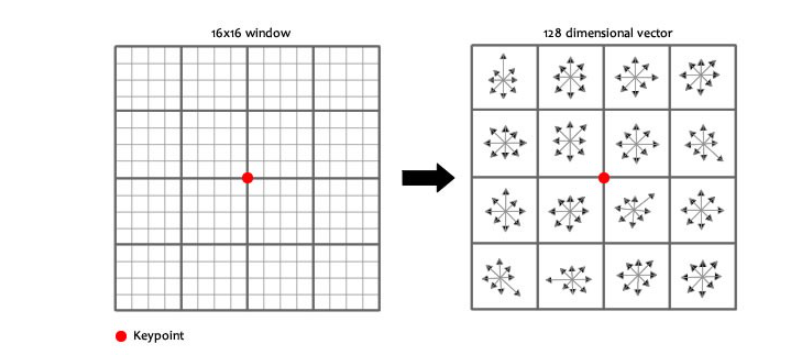

In [136]:
Image(filename="data/keypoint_descriptor.png",width=800)

For each sub-block,8 bin orientation histogram is created.

# 🔍 Finding the SIFT keypoints and descriptors

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv  

Let's first create our SIFT features extractor

In [114]:
sift = cv.SIFT_create()

<h4>Loading images in RGB Colorspace</h4>

In [117]:
train_img = cv.imread('data/train.jpg')
query_img = cv.imread('data/query.jpg')

<h4>Changing input image in 8-bit grayscale image</h4>

In [118]:
gray_train = cv.cvtColor(train_img,cv.COLOR_BGR2GRAY)
gray_query = cv.cvtColor(query_img,cv.COLOR_BGR2GRAY)

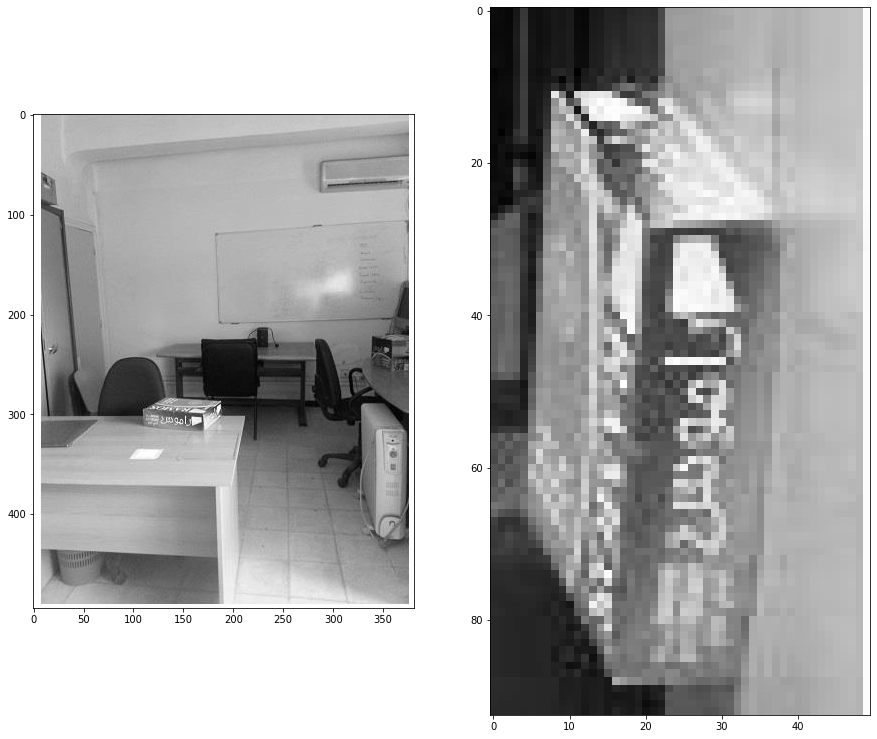

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(gray_train,cmap='gray')
ax2.imshow(gray_query,cmap='gray')

<h4>Detects keypoints and computes their descriptors</h4>

In [122]:
kp_train, desc_train = sift.detectAndCompute(gray_train, None)
kp_query, desc_query = sift.detectAndCompute(gray_query, None)

In [123]:
desc_train.shape

(362, 128)

<h4>Drawing the keypoints onto the images</h4>

In [124]:
result_query = cv.drawKeypoints(gray_query, kp_query, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
result_train = cv.drawKeypoints(gray_train, kp_train, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

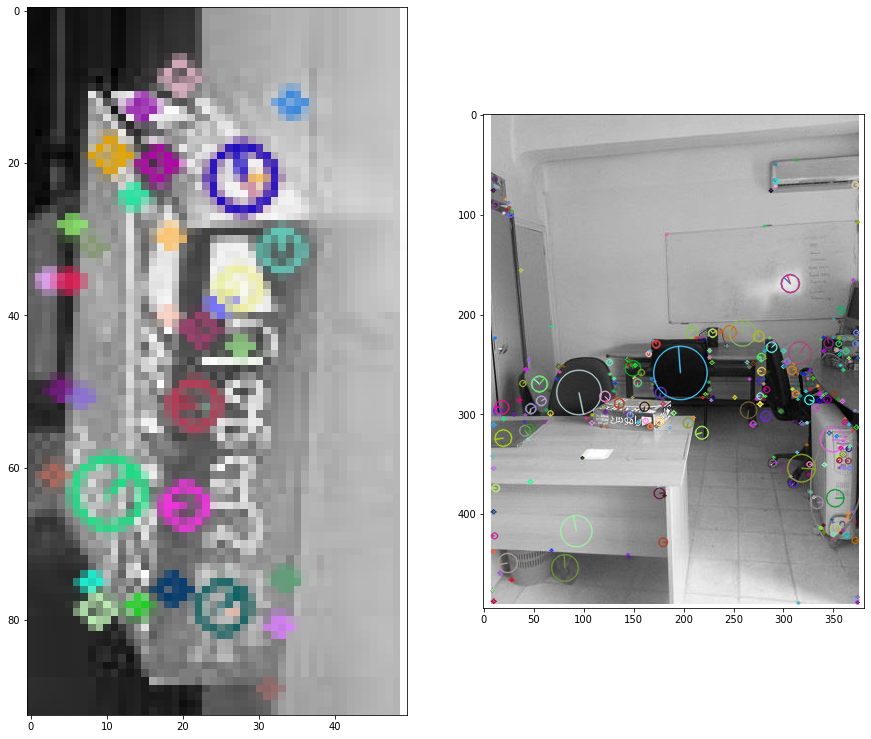

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(result_query,cmap='gray')
ax2.imshow(result_train,cmap='gray')

Let's look at the keypoints in details ! 

Let's focus on the first ten keypoints

In [126]:
for _,keypoint in enumerate(kp_train[:10]):
  x = keypoint.pt[0]
  y = keypoint.pt[1]
  s = keypoint.size
  print("""*Keypoint {} :
        x = {:.2f},
        y  = {:.2f},
        kp_size = {:.2f}""".format(_,x,y,s))

*Keypoint 0 :
        x = 9.53,
        y  = 341.44,
        kp_size = 3.08
*Keypoint 1 :
        x = 9.61,
        y  = 476.22,
        kp_size = 3.20
*Keypoint 2 :
        x = 9.90,
        y  = 341.59,
        kp_size = 3.62
*Keypoint 3 :
        x = 9.90,
        y  = 75.83,
        kp_size = 3.77
*Keypoint 4 :
        x = 10.01,
        y  = 476.04,
        kp_size = 3.76
*Keypoint 5 :
        x = 10.04,
        y  = 437.09,
        kp_size = 3.75
*Keypoint 6 :
        x = 10.14,
        y  = 353.81,
        kp_size = 4.16
*Keypoint 7 :
        x = 10.15,
        y  = 397.28,
        kp_size = 4.27
*Keypoint 8 :
        x = 10.22,
        y  = 310.29,
        kp_size = 4.31
*Keypoint 9 :
        x = 10.27,
        y  = 486.80,
        kp_size = 4.24


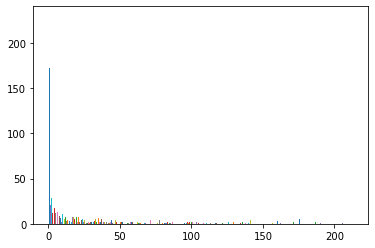

In [13]:
plt.hist(desc_train,bins = 180)
plt.show()

Histogram of the orientations

In [30]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

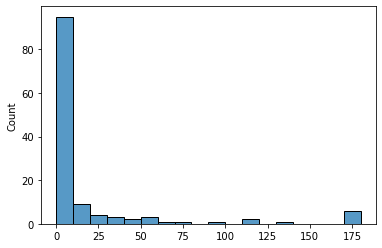

In [43]:
sns.histplot(data=desc_train[0], binwidth=10,binrange=[0,180])

# 🔧Feature Matching

To match SIFT features in one image with others, we may use the Brute-Force matcher in OpenCV.

**Brute-Force Matcher**
Takes the descriptor of one feature in first set and is matched with all other features in
second set using some distance calculation. The closest one is returned.




In [127]:
matches = cv.BFMatcher().knnMatch(desc_query,desc_train, k=2)

Here, we choose the best matches.

In [128]:
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

In [129]:
comparaison = cv.drawMatchesKnn(gray_query,kp_query,gray_train,kp_train,good,None,flags=2)

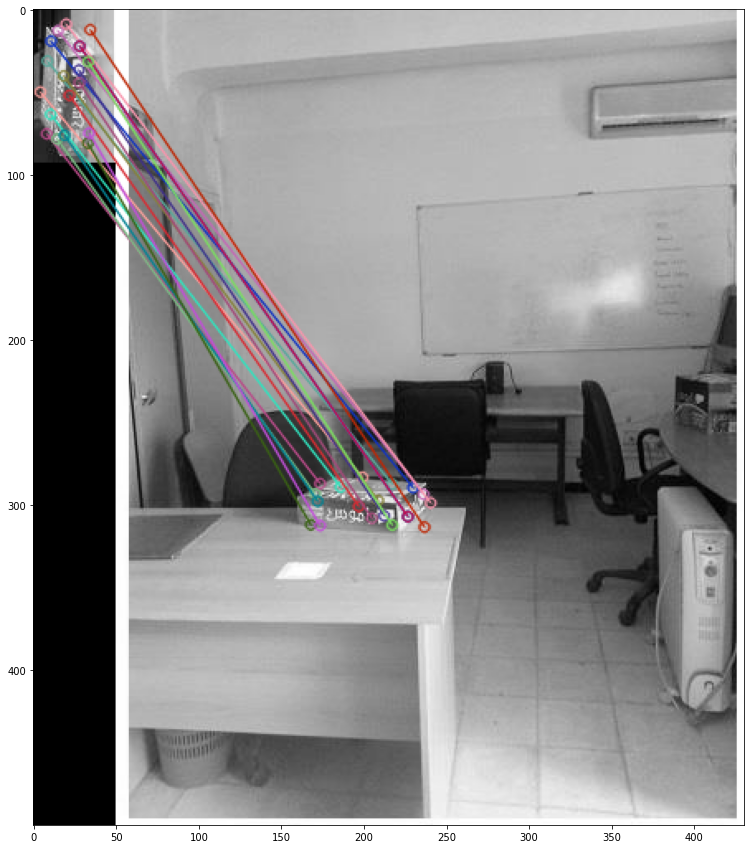

In [131]:
plt.figure(figsize=(15,15))
plt.imshow(comparaison)

# 📚 References
1. *Lecture 05 - Scale-invariant Feature Transform (SIFT)*,https://youtu.be/NPcMS49V5hg
2. *Introduction to SIFT( Scale Invariant Feature Transform)*, https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40
3. *SIFT Interest Point Detector Using Python*, https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/
4. *SIFT, OpenCV official documentation*,https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html